# Benchmark

In [1]:
import numpy as np
import bigvqe as bv
import autohf as hf
from pennylane import qchem
import chemistry as chem
from matplotlib import pyplot as plt
import time
from openfermion.chem.molecular_data import spinorb_from_spatial
from openfermion import jordan_wigner, get_sparse_operator, InteractionOperator, get_fermion_operator
import pennylane as qml
import openfermion

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In this Notebook, we benchmark the `bigvqe` method of generating sparse fermionic Hamiltonians against the currently implemented methods in PennyLane and OpenFermion. We begin by defining the molecules we will use in the simulations.

In [2]:
# BeH2 data (DO EXAMPLE)
beh2_structure = ['Be', 'H', 'H']
beh2_charges = [4, 1, 1]
beh2_orbitals = 7
beh2_R = np.array([0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, 0.0])
beh2_core, beh2_active = qchem.active_space(sum(beh2_charges), beh2_orbitals, active_electrons=sum(beh2_charges), active_orbitals=beh2_orbitals)

# Ammonia data
nh3_structure = ['N', 'H', 'H', 'H']
nh3_charges = [7, 1, 1, 1]
nh3_orbitals = 8
nh3_R = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0])
nh3_core, nh3_active = qchem.active_space(sum(nh3_charges), nh3_orbitals, active_electrons=sum(nh3_charges), active_orbitals=nh3_orbitals)

# Methane data
ch4_structure = ['C', 'H', 'H', 'H', 'H']
ch4_charges = [6, 1, 1, 1, 1]
ch4_orbitals = 9
ch4_R = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0])
ch4_core, ch4_active = qchem.active_space(sum(ch4_charges), ch4_orbitals, active_electrons=sum(ch4_charges), active_orbitals=ch4_orbitals)

In [3]:
##### BeH2 Hamiltonians #######

# Generates the electron integrals

basis_set = []
A1, A2, A3 = hf.basis_set_params("sto-3g", beh2_structure)

for func in A1 + A2 + A3:
    L, exp, coeff = func
    basis_set.append(hf.AtomicBasisFunction(L, C=np.array(coeff), A=np.array(exp)))

hf_b = [basis_set[0:5], [basis_set[5]], [basis_set[6]]]
elec_func = chem.electron_integrals(hf_b, sum(beh2_charges), beh2_charges, core=beh2_core, active=beh2_active)

core_ad, one, two = elec_func(beh2_R)

# Generates the Hamiltonians (note we dont add the core adjustment or nuclear repulsion)

#########################################

Ri = beh2_R.reshape((len(beh2_charges), 3))
geometry = list(zip(beh2_structure, (1 / chem.electronic.angs_bohr) * Ri))
wires = list(range(2 * beh2_orbitals))

start = time.time()
H_pl = qml.utils.sparse_hamiltonian(hf.build_h_from_integrals(geometry, one, two, 0.0, wires)) # PennyLane Hamiltonian
print("PennyLane time = {} seconds".format(time.time() - start))

#########################################

h1s, h2s = spinorb_from_spatial(one, two)
h2s = (1/2) * h2s
mol = InteractionOperator(0, h1s, h2s)
ham_fop = get_fermion_operator(mol)

start = time.time()
H_of = openfermion.linalg.jordan_wigner_sparse(ham_fop) # OpenFermion Hamiltonian
print("OpenFermion time = {} seconds".format(time.time() - start))

#########################################

start = time.time()
H_bv = bv.sparse_H(one, two) # BigVQE Hamiltonian
print("BigVQE time = {} seconds".format(time.time() - start))

PennyLane time = 4.257962386000001 seconds
OpenFermion time = 2.8014341560000027 seconds
BigVQE time = 0.21314844500000163 seconds


In [5]:
print(H_of - H_bv)

  (3, 3)	(1.3389692140180927+0j)
  (12, 3)	(0.4157662241426259+0j)
  (48, 3)	(0.02831154871188102+0j)
  (192, 3)	(0.028311548711881185+0j)
  (264, 3)	(-0.12097257374413761+0j)
  (516, 3)	(0.12097257374413761+0j)
  (768, 3)	(0.10483028379819359+0j)
  (1026, 3)	(0.37162825026669033+0j)
  (2049, 3)	(-0.37162825026669033+0j)
  (3072, 3)	(0.2940566085763847+0j)
  (4104, 3)	(0.08990564881730134+0j)
  (4608, 3)	(0.03662223737392071+0j)
  (8196, 3)	(-0.08990564881730134+0j)
  (8448, 3)	(-0.03662223737392071+0j)
  (12288, 3)	(0.02509288194196141+0j)
  (5, 5)	(-0.3175159998099444+0j)
  (257, 5)	(-0.06652523699017543+0j)
  (1028, 5)	(-0.019527215621588212+0j)
  (1280, 5)	(-0.027785820412512985+0j)
  (4097, 5)	(-0.01899922313593505+0j)
  (5120, 5)	(0.019364863670858573+0j)
  (6, 6)	(0.7332822239525569+0j)
  (9, 6)	(-1.0507982237625013+0j)
  (258, 6)	(0.18749781073431504+0j)
  (513, 6)	(-0.25402304772449047+0j)
  :	:
  (16126, 16378)	(-1.2033700125474753+0j)
  (16378, 16378)	(16.510799381989884+0j)

In [38]:
##### Ammonia Hamiltonians #######

# Generates the electron integrals

basis_set = []
A1, A2, A3, A4 = hf.basis_set_params("sto-3g", nh3_structure)

for func in A1 + A2 + A3 + A4:
    L, exp, coeff = func
    basis_set.append(hf.AtomicBasisFunction(L, C=np.array(coeff), A=np.array(exp)))

hf_b = [basis_set[0:5], [basis_set[5]], [basis_set[6]], [basis_set[7]]]
elec_func = chem.electron_integrals(hf_b, sum(nh3_charges), nh3_charges, core=nh3_core, active=nh3_active)

core_ad, one, two = elec_func(nh3_R)

# Generates the Hamiltonians (note we dont add the core adjustment or nuclear repulsion)

#########################################

Ri = nh3_R.reshape((len(nh3_charges), 3))
geometry = list(zip(nh3_structure, (1 / chem.electronic.angs_bohr) * Ri))
wires = list(range(2 * nh3_orbitals))

start = time.time()
H_pl = qml.utils.sparse_hamiltonian(hf.build_h_from_integrals(geometry, one, two, 0.0, wires)) # PennyLane Hamiltonian
print("PennyLane time = {} seconds".format(time.time() - start))

#########################################

h1s, h2s = spinorb_from_spatial(one, two)
h2s = (1/2) * h2s
mol = InteractionOperator(0, h1s, h2s)
ham_fop = get_fermion_operator(mol)

start = time.time()
H_of = openfermion.linalg.jordan_wigner_sparse(ham_fop) # OpenFermion Hamiltonian
print("OpenFermion time = {} seconds".format(time.time() - start))

#########################################

start = time.time()
H_bv = bv.sparse_H(one, two) # BigVQE Hamiltonian
print("BigVQE time = {} seconds".format(time.time() - start))

PennyLane time = 78.43107087000044 seconds
OpenFermion time = 19.112023925999893 seconds
BigVQE time = 0.8529782239993438 seconds


In [42]:
##### Methane Hamiltonians #######

# Generates the electron integrals

basis_set = []
A1, A2, A3, A4, A5 = hf.basis_set_params("sto-3g", ch4_structure)

for func in A1 + A2 + A3 + A4 + A5:
    L, exp, coeff = func
    basis_set.append(hf.AtomicBasisFunction(L, C=np.array(coeff), A=np.array(exp)))

hf_b = [basis_set[0:5], [basis_set[5]], [basis_set[6]], [basis_set[7]], [basis_set[8]]]
elec_func = chem.electron_integrals(hf_b, sum(ch4_charges), ch4_charges, core=ch4_core, active=ch4_active)

core_ad, one, two = elec_func(ch4_R)

# Generates the Hamiltonians (note we dont add the core adjustment or nuclear repulsion)

#########################################

Ri = ch4_R.reshape((len(ch4_charges), 3))
geometry = list(zip(ch4_structure, (1 / chem.electronic.angs_bohr) * Ri))
wires = list(range(2 * ch4_orbitals))

start = time.time()
H_pl = qml.utils.sparse_hamiltonian(hf.build_h_from_integrals(geometry, one, two, 0.0, wires)) # PennyLane Hamiltonian
print("PennyLane time = {} seconds".format(time.time() - start))

#########################################

h1s, h2s = spinorb_from_spatial(one, two)
h2s = (1/2) * h2s
mol = InteractionOperator(0, h1s, h2s)
ham_fop = get_fermion_operator(mol)

start = time.time()
H_of = openfermion.linalg.jordan_wigner_sparse(ham_fop) # OpenFermion Hamiltonian
print("OpenFermion time = {} seconds".format(time.time() - start))

#########################################

start = time.time()
H_bv = bv.sparse_H(one, two) # BigVQE Hamiltonian
print("BigVQE time = {} seconds".format(time.time() - start))

PennyLane time = 756.7170981239997 seconds
OpenFermion time = 114.18937235400062 seconds
BigVQE time = 2.9978779019993453 seconds


<AxesSubplot:xlabel='Hamiltonian'>

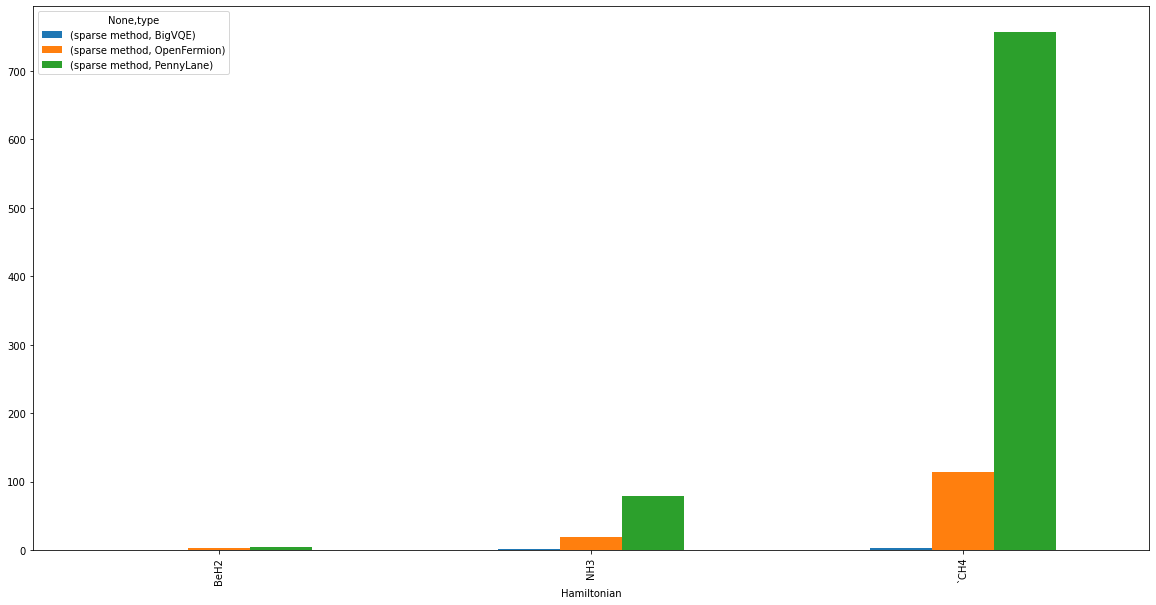

In [78]:
plt.rcParams["figure.figsize"] = [20, 10]

df = pd.DataFrame([['BeH2', 'BeH2', 'BeH2', 'NH3', 'NH3', 'NH3', '`CH4', '`CH4', '`CH4'],
                   ['PennyLane','OpenFermion','BigVQE', 'PennyLane','OpenFermion','BigVQE', 'PennyLane','OpenFermion','BigVQE'], 
                   [3.8648626419999346, 2.6027363729999706, 0.23977137800011405, 78.43107087000044, 19.112023925999893, 0.8529782239993438, 756.7170981239997, 114.18937235400062, 2.9978779019993453]]).T

df.columns = ['Hamiltonian', 'type', 'sparse method']
df.set_index(['Hamiltonian', 'type'], inplace=True)

df.unstack().plot.bar()